In [1]:
from dataclasses import dataclass, field
from multiprocessing import Lock
from typing import Sequence, Optional, Dict, ClassVar, Set

import clingo.ast
import descartes
import matplotlib.pyplot as plt
import telingo.theory as telingo_theory
import telingo.transformers as telingo_transformer
from clingo import PropagateInit, PropagateControl, Assignment
from clingo.ast import ProgramBuilder
from clingox.program import Program, ProgramObserver
from shapely.geometry import Polygon

In [2]:
db = {
    "square1": Polygon([(0, 0), (2, 0), (2, 2), (0, 2)]),
    "square2": Polygon([(1, 1), (3, 1), (3, 3), (1, 3)]),
}
db

{'square1': <shapely.geometry.polygon.Polygon at 0x7fd0f717d0c0>,
 'square2': <shapely.geometry.polygon.Polygon at 0x7fd1a00cf610>}

In [3]:
program = """

#program always.
type(polygon).

product(polygon, "square1").
product(polygon, "square2").

#program dynamic.
{ build(Id) } :- product(polygon, Id).

build(Id) :- 'build(Id).

&union{ P1;P2 } = merge(P1, P2) :- product(polygon, P1), product(polygon, P2), build(P1), build(P2), P1 < P2.

"""

In [4]:
theory = """
#theory spatial {
	constant  {};
	spatial_term {};
	&union/2 : spatial_term, {=}, constant, any;
	&intersect/2 : spatial_term, {=}, constant, any
}.
"""

In [5]:
def rewrap(theory_term: clingo.TheoryTerm):
    if theory_term.type is clingo.TheoryTermType.Symbol:
        return clingo.Function(theory_term.name)
    elif theory_term.type is clingo.TheoryTermType.Number:
        return clingo.Number(theory_term.number)
    elif theory_term.type is clingo.TheoryTermType.Function:
        name: str = theory_term.name
        arguments = (rewrap(argument) for argument in theory_term.arguments)
        return clingo.Function(name, tuple(arguments))
    arguments = (rewrap(argument) for argument in theory_term.arguments)
    if theory_term.type is clingo.TheoryTermType.Set:
        return clingo.String(str(set(arguments)))
    elif theory_term.type is clingo.TheoryTermType.Tuple:
        return clingo.Tuple_(tuple(arguments))
    elif theory_term.type is clingo.TheoryTermType.List:
        return clingo.String(str(list(arguments)))
    else:
        assert False, "Unknown TheoryTermType {} of TheoryTerm {}.".format(theory_term.type, theory_term)


def unwrap(theory_term: clingo.TheoryTerm):
    if theory_term.type is clingo.TheoryTermType.Symbol:
        if theory_term.name.startswith('"') and theory_term.name.endswith('"'):
            return theory_term.name[1:-1]
        return theory_term.name
    elif theory_term.type is clingo.TheoryTermType.Number:
        return theory_term.number
    elif theory_term.type is clingo.TheoryTermType.Function:
        name: str = theory_term.name
        arguments = (rewrap(argument) for argument in theory_term.arguments)
        return clingo.Function(name, tuple(arguments))
    arguments = (unwrap(argument) for argument in theory_term.arguments)
    if theory_term.type is clingo.TheoryTermType.Set:
        return set(arguments)
    elif theory_term.type is clingo.TheoryTermType.Tuple:
        return tuple(arguments)
    elif theory_term.type is clingo.TheoryTermType.List:
        return list(arguments)
    else:
        assert False, "Unknown TheoryTermType {} of TheoryTerm {}.".format(theory_term.type, theory_term)

In [6]:
class SpatialTheory:
    spatial_functions = ('union', 'intersect')
    spatial_theory_atoms = (*spatial_functions,)

In [7]:
class SpatialTransformer(clingo.ast.Transformer):

    def visit_Rule(self, rule: clingo.ast.AST, loc: Optional[str] = None):
        new_head = rule.head
        if rule.head.ast_type is clingo.ast.ASTType.TheoryAtom:
            new_head = self.visit(rule.head, 'head')
        new_body = []
        for literal in rule.body:
            new_literal = literal
            if literal.atom.ast_type == clingo.ast.ASTType.TheoryAtom:
                new_literal = self.visit(literal, 'body')
            new_body.append(new_literal)
        return clingo.ast.Rule(rule.location, new_head, new_body)

    def visit_TheoryAtom(self, theory_atom: clingo.ast.AST, loc: Optional[str] = None):
        if theory_atom.term.name in SpatialTheory.spatial_theory_atoms and loc is not None:
            theory_atom.term.arguments.insert(0, clingo.ast.Function(theory_atom.location, loc, [], False))
        return theory_atom


In [8]:
class SpatialTelingoTransformer(clingo.ast.Transformer):
    def visit_Rule(self, rule: clingo.ast.AST, time_function: Optional[clingo.ast.AST] = None):
        new_head = rule.head
        tf = time_function or clingo.ast.Function(rule.location, '__t', (), False)
        if rule.head.ast_type is clingo.ast.ASTType.TheoryAtom:
            new_head = self.visit(rule.head, tf)
        new_body = []
        for literal in rule.body:
            new_literal = literal
            if literal.atom.ast_type == clingo.ast.ASTType.TheoryAtom:
                new_literal = self.visit(literal, tf)
            new_body.append(new_literal)
        return clingo.ast.Rule(rule.location, new_head, new_body)

    def visit_TheoryAtom(self, theory_atom: clingo.ast.AST, time_function: Optional[clingo.ast.AST] = None):
        if time_function is not None and theory_atom.term.name in SpatialTheory.spatial_theory_atoms:
            theory_atom.term.arguments.append(time_function)
        return theory_atom

In [9]:
class SpatialPropagator(clingo.Propagator):

    def __init__(self, database: Optional[Dict[str, Polygon]] = None):
        self._l2t = {}  # literal -> (op, geoms, assign)
        self._lih = set()  # literals in head
        self._lib = set()  # literals in body
        self._a2l = {}  # assign -> set(literal)
        self._l2s = {}  # literal -> solver_literal
        self._s2l = {}  # solver_literal -> literal
        self._db = database or {}
        self._qrst = []

    def _get_qrst(self, thread_id: int):
        while thread_id >= len(self._qrst):
            self._qrst.append(QRST(self._db))
        return self._qrst[thread_id]

    def init(self, init: PropagateInit) -> None:
        print("[DEBUG]:", "Initializing SpatialPropagator")
        for atom in init.theory_atoms:
            if atom.term.name not in SpatialTheory.spatial_theory_atoms:
                continue
            term = atom.term
            args = tuple(unwrap(argument) for argument in atom.term.arguments[1:])
            op = term.name
            geoms = sorted(unwrap(element.terms[0]) for element in atom.elements)
            assign = unwrap(atom.guard[1])
            program_literal = atom.literal
            solver_literal = init.solver_literal(program_literal)
            if program_literal not in self._l2t:
                self._l2t[program_literal] = (op, args, geoms, assign)
            if program_literal not in self._l2s:
                self._l2s[program_literal] = solver_literal
            if solver_literal not in self._s2l:
                self._s2l[solver_literal] = program_literal
                init.add_watch(solver_literal)
            loc = term.arguments[0].name

            if loc == 'head':
                self._lih.add(program_literal)
                self._a2l.setdefault(assign, set()).add(program_literal)
                if init.assignment.is_true(solver_literal):
                    for thread_id in range(init.number_of_threads):
                        qrst = self._get_qrst(thread_id)
                        valid = qrst.evaluate(op, geoms, assign)
                        if not valid:
                            conflict = [-self._l2s[program_literal] for program_literal in self._a2l[assign]]
                            init.add_clause(conflict) and init.propagate()
                            return

            elif loc == 'body':
                self._lib.add(program_literal)

        for head_literal in self._lih:
            for body_literal in self._lib:
                if self._l2t[head_literal] == self._l2t[body_literal]:
                    head_solver_literal = self._l2s[head_literal]
                    body_solver_literal = self._l2s[body_literal]
                    init.add_clause((head_solver_literal, -body_solver_literal))
                    init.add_clause((-head_solver_literal, body_solver_literal))

    def propagate(self, control: PropagateControl, changes: Sequence[int]) -> None:
        for change in changes:
            if change in self._s2l:
                program_literal = self._s2l[change]
                if program_literal in self._lih:
                    op, args, geoms, assign = self._l2t[program_literal]
                    print("[DEBUG]:",
                          "Thread {}, Setting {}{}{} {} {} {} = {}".format(control.thread_id, '&', op, args, '{',
                                                                           ';'.join(geoms), '}', assign))
                    qrst: QRST = self._get_qrst(control.thread_id)
                    valid = qrst.evaluate(op, args, geoms, assign)
                    if not valid:
                        conflict = [self._l2s[program_literal] for program_literal in self._a2l[assign]]
                        control.add_nogood(conflict) and control.propagate()
                        return

        return

    def undo(self, thread_id: int, assignment: Assignment, changes: Sequence[int]) -> None:
        for change in changes:
            if change in self._s2l:
                program_literal = self._s2l[change]
                if program_literal in self._lih:
                    op, args, geoms, assign = self._l2t[program_literal]
                    print("[DEBUG]:",
                          "Thread {}: Backtracking {}{}{} {} {} {} = {}".format(thread_id, '&', op, args, '{',
                                                                                ';'.join(geoms),
                                                                                '}', assign))
                    qrst = self._get_qrst(thread_id)
                    qrst.backtrack(op, args, geoms, assign)
        return

    def on_model(self, model: clingo.Model) -> Optional[bool]:
        qrst = self._get_qrst(model.thread_id)
        geometry_symbols = tuple(
            clingo.Function('geometry', (clingo.String(geom_id), clingo.String(str(list(polygon.exterior.coords)))))
            for geom_id, polygon in qrst.db.items())
        assign_symbols = tuple(clingo.Function('assigned', (assign, clingo.String(list(geom_id)[0]))) for
                               assign, geom_id in qrst.assignments.items() if geom_id)
        model.extend(geometry_symbols)
        model.extend(assign_symbols)
        return

In [10]:

@dataclass
class QRST:
    db: Dict[str, Polygon] = field(default_factory=dict, repr=False)  # geom_id -> polygon
    assignments: Dict[clingo.Symbol, Set[str]] = field(
        default_factory=dict)  # assign -> set(geom_id)
    _db_lock: ClassVar[Lock] = Lock()

    def get_geom_id(self, operation: str, arguments: Sequence[clingo.Symbol], geoms: Sequence[str]):
        return "{}({}){}{}{}".format(operation, ','.join(map(str, arguments)), '{', ','.join(sorted(geoms)), '}')

    def evaluate(self, operation: str, arguments: Sequence[clingo.Symbol], geoms: Sequence[str],
                 assign: clingo.Symbol) -> bool:
        geom_id = self.get_geom_id(operation, arguments, geoms)
        if geom_id not in self.db:
            with QRST._db_lock:
                if geom_id not in self.db:
                    if operation == 'intersect':
                        self.intersect(geom_id, geoms)
                    elif operation == 'union':
                        self.union(geom_id, geoms)

        self.assignments.setdefault(assign, set()).add(geom_id)
        return len(self.assignments[assign]) == 1

    def backtrack(self, operation: str, arguments: Sequence[clingo.Symbol], geoms: Sequence[str],
                  assign: clingo.Symbol):
        assert assign in self.assignments, "clingo.Symbol {} should be in assignments.".format(assign)
        geom_id = self.get_geom_id(operation, arguments, geoms)
        assert geom_id in self.assignments[assign], "geom_id {} should be in assigned values of assign {}.".format(
            geom_id, assign)
        self.assignments[assign].remove(geom_id)

    def intersect(self, geom_id: str, geoms: Sequence[str]) -> None:
        polys = list(self.db[geom] for geom in geoms)
        new_poly = polys[0]
        i = 1
        while i < len(polys):
            new_poly = new_poly.intersection(polys[i])
            i += 1
        self.db[geom_id] = new_poly

    def union(self, geom_id: str, geoms: Sequence[str]) -> None:
        polys = list(self.db[geom] for geom in geoms)
        new_poly = polys[0]
        i = 1
        while i < len(polys):
            new_poly = new_poly.union(polys[i])
            i += 1
        self.db[geom_id] = new_poly

In [11]:
ctl = clingo.Control()
ctl.configuration.solve.models = 0

In [12]:
propagator = SpatialPropagator(db)
spatial_transformer = SpatialTransformer()
temporal_transformer = SpatialTelingoTransformer()

In [13]:
prg = Program()
obs = ProgramObserver(prg)

In [14]:
ctl.register_propagator(propagator)
ctl.register_observer(obs)

In [15]:
ctl.add('base', [], theory)
print(theory)
stmts_spatial = []
stmts_temporal = []
stmts_telingo = []
clingo.ast.parse_string(program, lambda stm: stmts_spatial.append(spatial_transformer.visit(stm)))
clingo.ast.parse_string('\n'.join(map(str, stmts_spatial)), lambda stm: stmts_temporal.append(temporal_transformer.visit(stm)))
future_sigs, program_parts = telingo_transformer.transform(['\n'.join(map(str, stmts_temporal))], stmts_telingo.append)
with ProgramBuilder(ctl) as builder:
    for stm in stmts_telingo:
        print(stm)
        builder.add(stm)


#theory spatial {
	constant  {};
	spatial_term {};
	&union/2 : spatial_term, {=}, constant, any;
	&intersect/2 : spatial_term, {=}, constant, any
}.

#program initial(__t, __u).
#program initial(__t, __u).
#program initial(__t, __u).
#program always(__t, __u).
type(polygon,__t).
product(polygon,"square1",__t).
product(polygon,"square2",__t).
#program dynamic(__t, __u).
{ build(Id,__t) } :- product(polygon,Id,__t).
build(Id,__t) :- build(Id,(__t+-1)).
&union(head,__t) { P1; P2 } = merge(P1,P2) :- product(polygon,P1,__t); product(polygon,P2,__t); build(P1,__t); build(P2,__t); P1 < P2.
#program initial(__t, __u).
__initial(__t).
#program always(__t, __u).
#external __final(__t). [false]
#theory tel {
  formula_body {
    & : 7, unary;
    - : 7, unary;
    + : 6, binary, left;
    - : 6, binary, left;
    ~ : 5, unary;
    < : 5, unary;
    < : 5, binary, right;
    <: : 5, unary;
    <: : 5, binary, right;
    <? : 5, unary;
    <* : 5, unary;
    << : 5, unary;
    > : 5, unary;
    > 

In [16]:
ctl.ground([('base', ())])

In [17]:
print(prg)

In [18]:
f = telingo_theory.Theory()
step, ret = 0, None

In [19]:
parts = []
assumptions = []
for root_name, part_name, rng in program_parts:
    for i in rng:
        if ((step - i >= 0 and root_name == "always") or
                (step - i > 0 and root_name == "dynamic") or
                (step - i == 0 and root_name == "initial")):
            parts.append((part_name, [clingo.Number(step - i), clingo.Number(step)]))
        if step > 0:
            ctl.release_external(clingo.Function("__final", [clingo.Number(step - 1)]))
        ctl.ground(parts)
        f.translate(step, ctl)
        ctl.assign_external(clingo.Function("__final", [clingo.Number(step)]), True)
        assumptions = []
        for name, arity, positive in future_sigs:
            for atom in ctl.symbolic_atoms.by_signature(name, arity, positive):
                if atom.symbol.arguments[-1].number > step:
                    assumptions.append(-atom.literal)

In [20]:
with ctl.solve(yield_=True, on_model=propagator.on_model, assumptions=assumptions) as solve_handle:
    models = []
    for model in solve_handle:
        symbols = sorted(model.symbols(shown=True, theory=True))
        models.append(model)
        print("Answer {}:".format(model.number), end=' ')
        print("{",
              '\n'.join(map(str, symbols)), "}", sep='\n')
    solve_result = solve_handle.get()
    print(solve_result, end='')
    if models:
        print(" {}{}".format(len(models), '' if solve_result.exhausted else '+'))

[DEBUG]: Initializing SpatialPropagator
Answer 1: {
__final(0)
__initial(0)
geometry("square1","[(0.0, 0.0), (2.0, 0.0), (2.0, 2.0), (0.0, 2.0), (0.0, 0.0)]")
geometry("square2","[(1.0, 1.0), (3.0, 1.0), (3.0, 3.0), (1.0, 3.0), (1.0, 1.0)]")
type(polygon,0)
product(polygon,"square1",0)
product(polygon,"square2",0)
}
SAT 1


In [21]:
step += 1
step

1

In [22]:
print("Literals -> (op, geoms, assign):")
print(propagator._l2t)
print("Literals in head:")
print(propagator._lih)
print("Literals in body:")
print(propagator._lib)
print("Assign -> literal:")
print(propagator._a2l)


Literals -> (op, geoms, assign):
{}
Literals in head:
set()
Literals in body:
set()
Assign -> literal:
{}


In [23]:
print("QRST:")
print(propagator._qrst)

QRST:
[QRST(assignments={})]


In [24]:
for geom_id, polygon in db.items():
    print("{}={}".format(geom_id, polygon))

square1=POLYGON ((0 0, 2 0, 2 2, 0 2, 0 0))
square2=POLYGON ((1 1, 3 1, 3 3, 1 3, 1 1))


/home/lukas/.local/share/miniconda/envs/asp-ideas/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


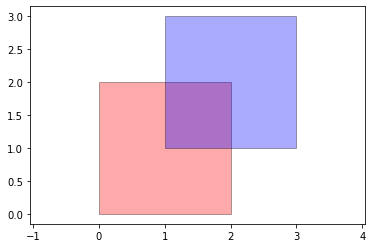

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.add_patch(descartes.PolygonPatch(db['square1'], fc='red', alpha=1 / 3))
ax.add_patch(descartes.PolygonPatch(db['square2'], fc='blue', alpha=1 / 3))
#ax.plot(*db['union(square1,square2)'].exterior.xy, color='green')
#ax.plot(*db['intersect(square1,square2)'].exterior.xy, color='violet')

ax.axis('equal')
plt.show()